<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [2]:
import gym
import highway_env
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [3]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [4]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [5]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [6]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 4
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [7]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[ 0.7914213   0.08466537  0.8596269  -0.6130368   2.7401903 ]
 [-0.92616034 -1.037354   -0.06236986 -0.8295883  -1.6887697 ]
 [-0.42051014 -0.7013899   0.51139015 -1.554946   -1.6017873 ]
 [-0.6488767   1.9025084   0.8368827  -0.3603859  -0.5567021 ]
 [ 0.10267998 -0.569971   -0.4342516  -0.6010843   1.1216875 ]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


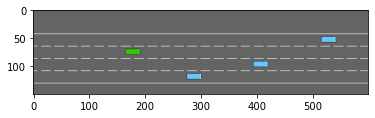

[[ 1.          0.9077264   0.25        0.3125      0.        ]
 [ 1.          0.0999883   0.5        -0.04683888  0.        ]
 [ 1.          0.20804437  0.25       -0.03083692  0.        ]
 [ 1.          0.31833214 -0.25       -0.03555275  0.        ]
 [ 1.          0.43481907  0.         -0.02355815  0.        ]]

Acción: LANE_RIGHT -> recommpensa: 0.8444444444444444
Nuevo estado:


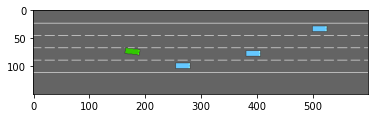

[[ 1.          1.          0.4582173   0.31063917  0.03405233]
 [ 1.          0.0813692   0.2917827  -0.05005691 -0.03405233]
 [ 1.          0.19611406  0.0417827  -0.03517903 -0.03405233]
 [ 1.          0.3040316  -0.4582173  -0.03967458 -0.03405233]
 [ 1.          0.4195314  -0.20821731 -0.05533974 -0.03405233]]

Acción: LANE_RIGHT -> recommpensa: 0.8666666666666667
Nuevo estado:


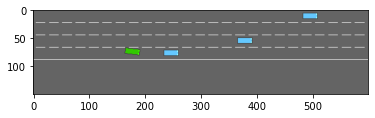

[[ 1.          1.          0.7219096   0.31064758  0.0339754 ]
 [ 1.          0.06184099  0.02809043 -0.05317559 -0.0339754 ]
 [ 1.          0.18183674 -0.22190957 -0.04176284 -0.0339754 ]
 [ 1.          0.28860992 -0.7219096  -0.04291799 -0.0339754 ]
 [ 1.          0.3989584  -0.47190955 -0.05172227 -0.0339754 ]]

Acción: IDLE -> recommpensa: 0.8666666666666667
Nuevo estado:


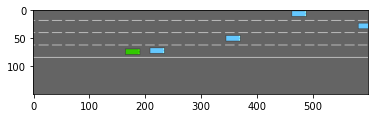

[[ 1.          1.          0.76615626  0.3124935  -0.00201384]
 [ 1.          0.03951476 -0.01615628 -0.05715047  0.00201384]
 [ 1.          0.16354844 -0.2661563  -0.04849479  0.00201384]
 [ 1.          0.27044815 -0.76615626 -0.04650817  0.00201384]
 [ 1.          0.37820393 -0.51615626 -0.05085659  0.00201384]]

Acción: FASTER -> recommpensa: 0.06666666666666665
Nuevo estado:


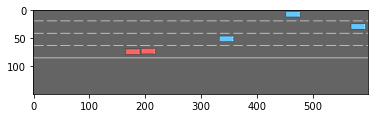

[[ 1.          1.          0.7512507   0.21632071 -0.00217799]
 [ 1.          0.02504912 -0.00230605 -0.05921775  0.00217799]
 [ 1.          0.15218437 -0.25125065  0.04390009  0.00217799]
 [ 1.          0.26042607 -0.7512507   0.04873104  0.00217799]
 [ 1.          0.3669406  -0.5012507   0.04679021  0.00217799]]
Episodio terminado después de 4 pasos y la recompensa fue 2.644444444444445


In [18]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))